This notebook computes 2pt correlation of excursion sets of enstropy from isotropic turbulence.   

In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

Import libraries: numpy for the generay array manipulations, pyFFTW to the Fourier Transforms, mpi4py for MPI support, general math, sys and os libraries and pyJHTDB, that provides a python wraper for the C-SOAP interface of the Johs Hopkins Turbulence Databases. We also import  modules that provide basic 3D FFT and histograming functionality build upon numpy and pyFFTW, as a way to streamline the overall process. These modules, which include FFT3Dfield, IFFT3Dfield and EnergySpectrum, were originaly developed by Dr. Kun Yang.

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

Initialize general domain constants, based on the isotropic1024coarse dictionary, which provide information on the isotropic turbulence database. We then initialize MPI variables, including the communicator, rank and number of process. Typical number of processes to be used is 8. Then, initalize the variables that designate the domain associated with each MPI process. We divide the domain in slabs split in the X direction. Also, constants related to wavenumber and chunck size downloads are initialized.

In [3]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

# Computational Domain

nx=Nx//nproc; ny=Ny; nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:3] 
n_proc = 8
rank = 0


Another notebook must have precomputed enstrophy. Here we load the cached value of enstrophy as pre-computed from a previous notebook.  

In [4]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch/turb_vort"
filename = "enstrophy-"+str(rank)+".npz"

file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] 
Finished loading
Load from disk: 4.22 seconds


Compute the global average of enstrophy, minimum and maximum values for reference.

In [5]:
%%px

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("<w^2> : "+str(avgOmega))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("max w2/<w^2> : "+str(maxw2/avgOmega))

[stdout:3] 
<w^2> : 498.43548584
min w2/<w^2> : 1.44143304223e-07
max w2/<w^2> : 675.170251839


Allocate all arrays we need to do the calculations of the 2-point correlation function.  

In [6]:
%%px

dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

comm.Barrier(); t1=MPI.Wtime()

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

X = np.zeros((nx,ny,nz), dtype='float32')
Y = np.zeros((nx,ny,nz), dtype='float32')
Z = np.zeros((nx,ny,nz), dtype='float32')

r2 = np.zeros((nx,ny,nz), dtype='float32')

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')
cchi = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
corr = ft.zeros_aligned((nx,ny,nz),dtype='float32')

corrSum=np.zeros(ner,dtype='float32')
corrF=np.zeros(ner,dtype='float32')
corrF1=np.zeros(ner,dtype='float32')

r2Sum=np.zeros(ner,dtype='float32')
r2F=np.zeros(ner,dtype='float32') 

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] Alocating vectors: 24.64 seconds


[output:2]

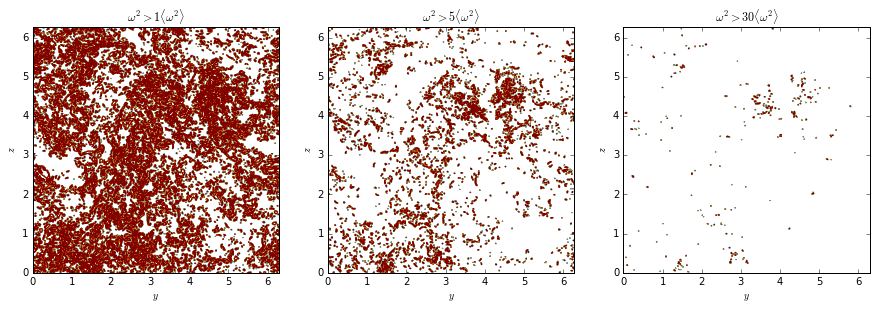

In [7]:
%%px 
%matplotlib inline

if(rank==1):
    plt.figure(figsize=(15,10))
    t = [1,5,30]
    for i in range(3): 
        chi[:,:,:] = 0
        chi[w2 > t[i]*avgOmega] = 1
        
        slice0 = chi[0,:,:] 
        
        xlist = np.linspace(0,2*math.pi, Ny)
        ylist = np.linspace(0,2*math.pi, Nz)
        Y1, Z1 = np.meshgrid(xlist, ylist)
        
        ax = plt.subplot(2,3,i+1)
        plt.contour(Y1, Z1, slice0)

        ax.set_title(r'$\omega^2>'+str(t[i])+r' \langle \omega^2\rangle $')
                
        plt.xlabel(r'$y$')
        plt.ylabel(r'$z$')
        plt.gca().set_aspect('equal', adjustable='box')
        
    plt.show()

To properly arrange the real space radius to do the spherical integration, we need to assign the distance from the first coordinate, so we compute X, Y and Z arrays, with the respective coordinates, and from there we compute the distance squared to the origin. This is so because the relevant information is contained in the first octant, so all we need is to integrate spherically the first octant. This section takes a fair share of time, around 200-220 seconds. On vm04, this is taking around 23 seconds. 

In [8]:
%%px

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    if (i+rank*nx < Nx//2):
        X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']
    else:
        X[i,:,:] = Lx-(i+rank*nx)*isotropic1024coarse['dx']

for j in range(ny):
    if (j < Ny//2):
        Y[:,j,:] = j*isotropic1024coarse['dy']
    else:
        Y[:,j,:] = Ly-j*isotropic1024coarse['dy']
    
for k in range(nz):
    if (k < Nz//2):
        Z[:,:,k] = k*isotropic1024coarse['dz']
    else:
        Z[:,:,k] = Lz-k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:3] Preparing the real domain for radial integration: 22.60 seconds


The computation of the full radial 2-point correlation function is done here, including the fourier transform and radial integration. The full computation takes around 80 seconds, on VM04. The breakdown time measured is:

Creating the excursion set: 1.18 seconds

Computing the 2-point correlation function: 48.87 seconds

Cleaning all but the 1st octant: 2.15 seconds

Integrating radially on each slab: 29.60 seconds

Adding the results form different slabs: 0.00 seconds

Full radial 2-point correlation calculation: 81.80 seconds

In [9]:
%%px 

t = 25
c = 'r'

hist = []
r2st = []
    
#######################################

comm.Barrier(); t1=MPI.Wtime()

chi[:,:,:] = 0
chi[w2 > t*avgOmega] = 1

#######################################

comm.Barrier(); t2=MPI.Wtime()
cchi[:,:,:] = fft.forward3Dfft(chi,nx,ny,nz,nproc,rank)
    
tmp = cchi*(cchi.conj())
corr[:,:,:] = fft.backward3Dfft(tmp,nx,ny,nz,nproc,rank)
    
#######################################
    
comm.Barrier(); t3=MPI.Wtime()
        
#######################################
    
comm.Barrier(); t4=MPI.Wtime()
    
corrLoc,redges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=corr)
    
r2Loc,r2edges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins)
       
#######################################
    
comm.Barrier(); t5=MPI.Wtime()
    
corrLoc=np.float32(corrLoc)
comm.Reduce([corrLoc,MPI.REAL],[corrSum,MPI.REAL],op=MPI.SUM)
np.copyto(corrF,corrSum)
    
corrApend=np.zeros(ner,dtype='float32') 
corrApend[:] = corrF[:]
    
#########################
    
r2Loc=np.float32(r2Loc)
comm.Reduce([r2Loc,MPI.REAL],[r2Sum,MPI.REAL],op=MPI.SUM)
np.copyto(r2F,r2Sum)
    
r2Apend=np.zeros(ner,dtype='float32') 
r2Apend[:] = r2F[:]
    
if rank==0:
    hist.append(corrApend[:])
    r2st.append(r2Apend[:])
    
#######################################
    
comm.Barrier(); t6=MPI.Wtime()
    
if rank==0:
    sys.stdout.write('threshold used: {0:.2f} \n'.format(t))
    sys.stdout.write('Creating the excursion set: {0:.2f} seconds\n'.format(t2-t1))
    sys.stdout.write('Computing the 2-point correlation function: {0:.2f} seconds\n'.format(t3-t2))
    sys.stdout.write('Cleaning all but the 1st octant: {0:.2f} seconds\n'.format(t4-t3))
    sys.stdout.write('Integrating radially on each slab: {0:.2f} seconds\n'.format(t5-t4))
    sys.stdout.write('Adding the results form different slabs: {0:.2f} seconds\n'.format(t6-t5))
    sys.stdout.write('Full radial 2-point correlation calculation: {0:.2f} seconds\n'.format(t6-t1))
    sys.stdout.write('\n')

[stdout:3] 
threshold used: 25.00 
Creating the excursion set: 1.16 seconds
Computing the 2-point correlation function: 49.92 seconds
Cleaning all but the 1st octant: 0.00 seconds
Integrating radially on each slab: 30.12 seconds
Adding the results form different slabs: 0.00 seconds
Full radial 2-point correlation calculation: 81.21 seconds



Finally, plotting the results:

[stdout:3] t = 25*sigma_2: Linear fit [alpha A] = [-0.83109409 -6.24155439]


[output:3]

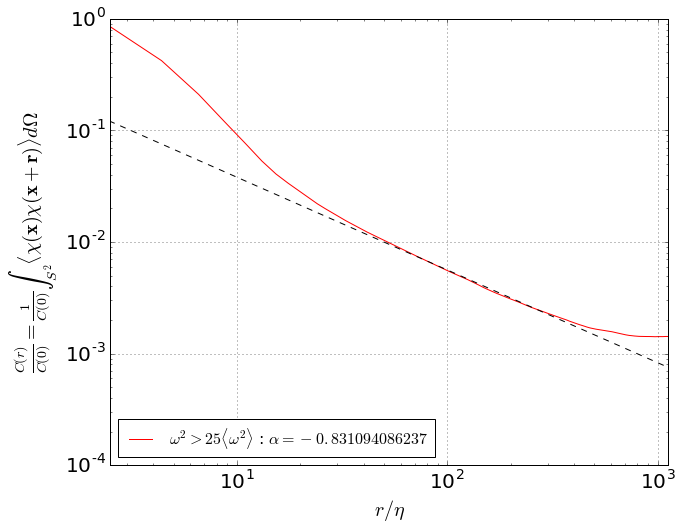

In [10]:
%%px
%matplotlib inline

eta = 0.00280

if(rank==0):
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    
    idx = r2st[0]>0
    
    rp=np.linspace(1*dx,ner*dx,ner)
    
    lrp = rp[idx]
    
    tempRp = lrp[(lrp>0.1)&(lrp<1.0)]
    plt.figure(figsize=(10,8))
    plt.xlabel(r'$r/\eta$', fontsize=20)
    plt.ylabel(r'$\frac{C(r)}{C(0)} = \frac{1}{C(0)} \int_{S^2} \langle \chi({\bf x}) \chi({\bf x}+{\bf r}) \rangle d\Omega$', fontsize=20)
    plt.xlim([7*10**(-3)/eta,np.pi/eta])
    #plt.ylim([1*10**(-4),1*10**0])   
    
    corrF1 = hist[0][idx]/r2st[0][idx]
    tempCorrF = corrF1[(lrp>0.1)&(lrp<1.0)]
        
    ctmp = (corrF1[300])/(corrF1[0])
        
    fit = np.polyfit(np.log(tempRp),np.log(tempCorrF/corrF1[0]),1)
    print("t = "+str(t)+"*sigma_2: Linear fit [alpha A] = "+str(fit))
        
    plt.loglog(lrp/eta,(corrF1)/(corrF1[0]),c,label=r'$\omega^2 > '+str(t)
                                               +r'\langle \omega^2\rangle$ : $\alpha ='
                                               +str(fit[0])+r'$')
        
    plt.loglog(lrp/eta,np.exp(fit[1])*(lrp**(fit[0])),'k--')
    
    #ticks = [3.5,5,7.5,10,15,20,25,30,35,42.5,50,60,75,100,125,150,175,215,250,300,350,425,500,600,750,875,1024]
    #labels = [str(s) for s in ticks]
    #plt.xticks(ticks,labels,rotation='vertical')
    plt.grid()
        
    plt.legend(loc='lower left',prop={'size':16})